# Fake job Detection: Investigating Fake job posts to avoid the job scam

# Notebook 5  Neural network and Modeling

**Fifth setp: Modeling with Pre-trained word vectors and Neural network**

By: Polly Pang

In this portion of the notebook, I will use Pre-trained word vectors, convert text column into sparse metrics. And implement traditional Ml models and also Neural network model.

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home"> Contents</h3>

* [1. Libraries](#1)
* [2. Load data](#2)
* [3. NLP](#3)
    - [3.1 Pre-process](#3.1)
* [4. Word Embeddings](#4)
    - [4.1 Word2Vec](#4.1)
    - [4.2 GloVe](#4.2)
* [5. Modeling](#5)
    - [5.1 oversampling](#5.1)

    
    
    
* [7. End of Notebook 5](#7)

# 1. Libraries <a id="1"></a>

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
from sklearn.model_selection import train_test_split

# NLP
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from tqdm import tqdm

from imblearn.over_sampling import SMOTE

# model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Activation, Dense,Dropout
from sklearn.linear_model import LogisticRegression

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

#from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# 2. Load data

## 2.1 Target and Feature<a id="2.1"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

**plan**
- Define X and y, Target :`fraudulent`, Features:`has_salary_range`,`telecommuting`,`has_company_logo`,`has_questions`,and `text`.
- split data into test set and reminder set, as I will process Cross-Validation in the follwing part, so I will not split my dataset into train and test.
- investigate the distribustion of reminder set.

In [28]:
# load data
word_embed_df=joblib.load('data/df_model_full_df.pkl')

In [29]:
# sample of dataset
word_embed_df

,has_salary_range,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,0,1,0,0,"Marketing Intern Marketing We're Food52, and w..."
1,0,0,1,0,0,Commissioning Machinery Assistant (CMA) Blank ...
2,0,0,1,0,0,Account Executive - Washington DC Sales Our pa...
3,0,0,1,1,0,Bill Review Manager Blank SpotSource Solutions...
4,0,0,0,0,0,Accounting Clerk Blank Blank Job OverviewApex ...
...,...,...,...,...,...,...
17874,0,0,1,1,0,Account Director - Distribution Sales Vend is ...
17875,0,0,1,1,0,Payroll Accountant Accounting WebLinc is the e...
17876,0,0,0,0,0,Project Cost Control Staff Engineer - Cost Con...
17877,0,0,0,1,0,Graphic Designer Blank Blank Nemsia Studios is...


In [30]:
print(f"The shape of word_embed_df is {word_embed_df.shape}")

The shape of word_embed_df is (17879, 6)


In [31]:
word_embed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17879 entries, 0 to 17878
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   has_salary_range  17879 non-null  int32 
 1   telecommuting     17879 non-null  int64 
 2   has_company_logo  17879 non-null  int64 
 3   has_questions     17879 non-null  int64 
 4   fraudulent        17879 non-null  int64 
 5   text              17879 non-null  object
dtypes: int32(1), int64(4), object(1)
memory usage: 768.4+ KB


**Define Target and Features**

In [32]:
# define X and y
X=word_embed_df.drop('fraudulent',axis=1)
y=word_embed_df['fraudulent']

In [33]:
print(f"The shape of features(X) is {X.shape},and the shape of y (Target) is {y.shape}")

The shape of features(X) is (17879, 5),and the shape of y (Target) is (17879,)


**Reminder and test split**

In [34]:
X_rem,X_test,y_rem,y_test=train_test_split(X,y,test_size=0.3,random_state=5, stratify=y)

In [35]:
print(f"The shape of X_reminder is {X_rem.shape},and the shape of y_rem is {y_rem.shape}")

The shape of X_reminder is (12515, 5),and the shape of y_rem is (12515,)


In [36]:
print(f"The shape of X_test is {X_test.shape},and the shape of y_test is {y_test.shape}")

The shape of X_test is (5364, 5),and the shape of y_test is (5364,)


In [37]:
X_rem.head()

,has_salary_range,telecommuting,has_company_logo,has_questions,text
4310,0,0,1,1,Creative Director - Art Blank Kettle is an ind...
11082,0,0,1,0,"CDL Driver Blank ABC Supply Co., Inc. is the n..."
14188,0,0,1,0,Data Analyst (Marketing) Blank Blank We are lo...
8280,0,0,1,1,Channel Representative Blank Intercom (# is a ...
13924,0,0,1,0,Programmatic Media Manager Media Since 1978Our...


In [38]:
y_rem.unique()

array([0, 1], dtype=int64)

In [39]:
X_test.head()

,has_salary_range,telecommuting,has_company_logo,has_questions,text
8222,1,0,1,0,eCommerce Specialist / Database Management for...
1560,0,0,1,1,Solution Engineer Blank Declara is focused on ...
17171,1,0,0,1,Sales Representative for Home Improvement Blan...
9164,0,0,1,1,Customer Service Specialist Interpreting Servi...
9454,0,0,1,0,Customer Service Associate - Records Blank Nov...


In [40]:
y_test.unique()

array([0, 1], dtype=int64)

- X_rem and X_test have same features, and y_test and y_rem contains only 2 result.
- 2 Reminder sets and test stes have same number of rows.
- Now I have my reminder and test set ready.
---

# 3. NLP

## 3.1 Pre-process<a id="3.1"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

**Plan**
- Define function text_process()
- Transform X_rem and X_test


**Function text_process()**

**What does the function do**
- lowercase all the text
- Get rid of extra blank
- Take out of stopwords
- Take out puncuations
- Stemming
- Combine all the text back to a sentence

In [41]:
# init stemmer
stemmer = nltk.stem.PorterStemmer()
# make tokens
def text_process(text):
    non_pun=''.join([w for w in text.lower() if w not in string.punctuation])

    lst_words=non_pun.split(' ')
    #print(lst_words)
    # remove stop words and stem
    lst_out=[]
    for w in lst_words:
        if (w not in stopwords.words('english')) and (w != ""):
            stemmed_word = stemmer.stem(w)
            lst_out.append(stemmed_word)
    # combine list into sentence
            sentence = ' '.join(lst_out)
    return sentence

In [42]:
# test result
text_process(X_rem['text'][0])

'market intern market food52 weve creat groundbreak awardwin cook site support connect celebr home cook give everyth need one placew top editori busi engin team focus use technolog find new better way connect peopl around specif food interest offer superb highli curat inform food cook attract talent home cook contributor countri also publish wellknown profession like mario batali gwyneth paltrow danni meyer partnership whole food market random housefood52 name best food websit jame beard foundat iacp featur new york time npr pando daili techcrunch today showwer locat chelsea new york citi food52 fastgrow jame beard awardwin onlin food commun crowdsourc curat recip hub current interview full parttim unpaid intern work small team editor execut develop new york citi headquartersreproduc andor repackag exist food52 content number partner site huffington post yahoo buzzfe variou content manag systemsresearch blog websit provis food52 affili programassist daytoday affili program support scre

In [43]:
# compare with the orignal text
X_rem['text'][0]

"Marketing Intern Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community and crowd-sour

**Note: This `text` pre-process process is quite time-consuming, if you don't want to run this, you can load from my pickle files**

**File list**
- X_rem_stem.pkl stemmed X_rem
- X_test_stem.pkl stemmed X_test

**skip text preprocess step if you want to save time**

In [ ]:
# X_rem pre-process 
X_rem_stem=X_rem.copy()
X_rem_stem['text']=X_rem_stem['text'].apply(text_process)

In [ ]:
X_rem_stem.shape==X_rem.shape

In [ ]:
X_rem_stem.shape

In [ ]:
# X_test pre-process 
X_test_stem=X_test.copy()
X_test_stem['text']=X_test_stem['text'].apply(text_process)

In [ ]:
X_test.shape==X_test_stem.shape

In [ ]:
X_test_stem.shape

In [ ]:
# dump stemmed X_rem
joblib.dump(X_rem_stem,'data_NN/X_rem_stem.pkl')

In [ ]:
# dump stemmed X_test
joblib.dump(X_test_stem,'data_NN/X_test_stem.pkl')

**Load my result X_rem_stem and X_test_stem directly**

In [246]:
X_rem_stem_r=joblib.load('data_NN/X_rem_stem.pkl')
X_test_stem_r=joblib.load('data_NN/X_test_stem.pkl')

- X_rem and X_test has been transfered, moving forward I will keep NLP precoess using X_test_stem and X_rem_stem.

**Note: The previous text pre-process step take quite long time, I will use my dump result moving forward.**


---

# 4. Word Embeddings

## 4.1 Word2Vec<a id="4.1"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>


**Inro**

- Word2Vec, you need to down load and unzip the pre_trained word vectors. load pretrained vectors: we will use [LexVec](https://github.com/alexandres/lexvec) and Wikipedia.
- This is a 300-dimensional embeddings.

In [239]:
# load model
model = gensim.models.KeyedVectors.load_word2vec_format('word_vectors/lexvec-wikipedia-word-vectors', binary=False)

In [240]:
def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. 
    Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

In [247]:
test=X_rem_stem_r['text'][0]

In [248]:
# run test on function sentence2vec, funtion sentence2vec will vectorlize a chunk of words and make them into vectors.
sentence2vec(test)

array([ 6.74341045e-03,  1.47785036e-02,  5.18470079e-02, -4.48522844e-02,
       -2.32123977e-02,  7.35103956e-02, -7.02376553e-02, -5.86331787e-02,
        2.72017154e-02,  3.71126025e-02,  6.18962439e-02,  6.79209924e-02,
       -6.13002897e-02,  3.52634207e-02,  2.85057258e-02, -8.66618409e-03,
       -5.40745569e-02,  1.24067808e-02,  1.81927631e-02,  2.75717560e-02,
       -4.87615723e-02, -1.25809813e-03,  5.34995272e-02,  3.95418914e-02,
       -4.34269696e-02,  1.93284652e-03,  5.51410959e-02,  9.17166852e-02,
        5.33706070e-02,  7.19878818e-03, -5.27638614e-02, -1.21628942e-02,
        8.86199968e-03, -1.11307108e-02, -2.01904659e-02,  2.45921786e-02,
        3.41809196e-02, -2.82615622e-02, -1.13043402e-02,  3.55892729e-05,
        3.59347051e-02,  9.14204037e-03, -5.65660100e-02, -8.42303885e-02,
       -1.88666553e-02, -5.00674356e-02,  1.24683323e-02,  8.01085988e-04,
       -4.29462464e-02, -1.46393554e-02,  2.80085617e-02,  1.34663207e-03,
       -1.11906828e-02, -

In [249]:
#  300-dimensional
sentence2vec(test).shape

(300,)

In [250]:
numerical = list(X_rem_stem_r.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Numerical columns are: ['has_salary_range', 'telecommuting', 'has_company_logo', 'has_questions']


In [251]:
text = list(X_rem_stem_r.select_dtypes('object').columns)
print(f"text columns is: {text}")

text columns is: ['text']


**Apply sentence2vec function**

**Plan**
- Apply sentence2vec() on X_rem_stem[text] combine transformed df with X_rem_stem[numerical]
- Apply sentence2vec() on X_rem_test[text] combine transformed df with X_rem_test[numerical]

**X_rem_stem**

In [252]:
X_rem_stem_r

,has_salary_range,telecommuting,has_company_logo,has_questions,text
4310,0,0,1,1,Creative Director - Art Blank Kettle is an ind...
11082,0,0,1,0,"CDL Driver Blank ABC Supply Co., Inc. is the n..."
14188,0,0,1,0,Data Analyst (Marketing) Blank Blank We are lo...
8280,0,0,1,1,Channel Representative Blank Intercom (# is a ...
13924,0,0,1,0,Programmatic Media Manager Media Since 1978Our...
...,...,...,...,...,...
1344,0,0,1,1,Sales Manager - Legal Services Sales Pardon Se...
7561,0,0,1,1,Texas Communication Assistant CSD Relay Why CS...
16552,1,0,1,0,"Director, Information Security Blank Blank Dir..."
14072,0,0,1,1,Sales & Support role Blank Blank We are a smal...


In [253]:
X_rem_word2vec_text = np.array([sentence2vec(x) for x in tqdm(X_rem_stem_r['text'])])

100%|██████████| 12515/12515 [00:35<00:00, 351.41it/s]


In [254]:
# keep the original row and 300d
X_rem_word2vec_text.shape

(12515, 300)

In [255]:
X_wv_text_df=pd.DataFrame(X_rem_word2vec_text).reset_index(drop=True)

In [256]:
print(f"The shape of X_wv_text_df is {X_wv_text_df.shape}")

The shape of X_wv_text_df is (12515, 300)


In [257]:
X_num_stem_df=X_rem_stem_r[numerical].reset_index(drop=True)
X_num_stem_df

,has_salary_range,telecommuting,has_company_logo,has_questions
0,0,0,1,1
1,0,0,1,0
2,0,0,1,0
3,0,0,1,1
4,0,0,1,0
...,...,...,...,...
12510,0,0,1,1
12511,0,0,1,1
12512,1,0,1,0
12513,0,0,1,1


In [258]:
# check if X_wv_text_df and X_num_stem_df has the same rows.
X_wv_text_df.shape[0]==X_num_stem_df.shape[0]

True

In [259]:
X_rem_wv_df=pd.concat([X_wv_text_df,X_num_stem_df],axis=1)

In [260]:
# transformed X_rem df
X_rem_wv_df

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,has_salary_range,telecommuting,has_company_logo,has_questions
0,0.032685,0.030730,0.044741,-0.048046,-0.023740,0.069754,-0.085251,-0.081625,0.003326,0.032455,...,0.007239,0.025612,0.004509,-0.029718,-0.029850,0.010457,0,0,1,1
1,0.001888,-0.009283,0.046821,-0.030805,-0.031311,0.053163,-0.066486,-0.071417,0.007226,0.033280,...,0.001848,0.057129,0.031200,-0.049951,-0.002064,-0.014311,0,0,1,0
2,0.001702,0.017523,0.041336,-0.064283,-0.011654,0.060083,-0.094541,-0.063665,0.033909,0.026475,...,0.016631,0.030980,0.015536,-0.040767,-0.010167,0.015519,0,0,1,0
3,0.010606,0.012670,0.037562,-0.035672,-0.020939,0.058435,-0.086041,-0.052790,0.032813,0.030854,...,0.021882,0.036611,0.022881,-0.029615,-0.020560,-0.004619,0,0,1,1
4,-0.001269,0.015532,0.054022,-0.064340,-0.027642,0.061069,-0.072444,-0.042063,0.045245,0.022422,...,0.011772,0.024864,0.028411,-0.019539,-0.028128,0.002730,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12510,-0.012657,0.010604,0.031436,-0.063076,-0.022296,0.031369,-0.100525,-0.053420,0.031306,0.030024,...,0.005301,0.022006,0.039932,-0.020936,-0.024622,-0.006558,0,0,1,1
12511,0.031819,0.022081,0.061195,-0.050659,-0.007663,0.067053,-0.088835,-0.055991,0.017140,0.020551,...,0.029177,0.036914,0.009130,-0.031829,-0.026540,-0.009258,0,0,1,1
12512,-0.008422,0.066171,0.007626,-0.021893,0.042899,0.061828,-0.117880,-0.058940,0.062139,0.012622,...,0.027131,0.040198,0.004391,-0.092511,-0.012208,0.032884,1,0,1,0
12513,-0.008137,-0.027150,0.017740,-0.042628,-0.003595,0.046319,-0.067264,-0.076473,0.036141,0.020093,...,0.010358,0.053446,0.038119,-0.023134,-0.000326,-0.021855,0,0,1,1


In [261]:
X_rem_wv_df.shape

(12515, 304)

In [262]:
# there is no nan in the X_rem_wv_df
X_rem_wv_df.isna().sum().sum()

0

**X_rem_test**

In [263]:
X_test_stem_r

,has_salary_range,telecommuting,has_company_logo,has_questions,text
8222,1,0,1,0,ecommerc specialist databas manag home decor c...
1560,0,0,1,1,solut engin blank declara focus bring data lif...
17171,1,0,0,1,sale repres home improv blank blank look good ...
9164,0,0,1,1,custom servic specialist interpret servic rela...
9454,0,0,1,0,custom servic associ record blank novitex ente...
...,...,...,...,...,...
2611,0,0,1,0,stock manag blank blank execut flow merchandis...
11822,0,0,1,0,cabl tech night shift blank tel tech network v...
10961,0,0,1,1,advisori consult associ blank green street adv...
13509,0,0,1,0,dish washer 3040 hr per week blank belfri inn ...


In [264]:
X_test_word2vec_text = np.array([sentence2vec(x) for x in tqdm(X_test_stem_r['text'])])

100%|██████████| 5364/5364 [00:08<00:00, 643.13it/s]


In [265]:
# keep the original row and 300d
X_test_word2vec_text.shape

(5364, 300)

In [266]:
X_test_wv_text_df=pd.DataFrame(X_test_word2vec_text).reset_index(drop=True)

In [267]:
# check if transformed df shape is not changed 
X_test_wv_text_df.shape==X_test_word2vec_text.shape

True

In [268]:
X_test_num_stem_df=X_test_stem_r[numerical].reset_index(drop=True)

In [269]:
# check if transformed df shape is not changed 
X_test_num_stem_df.shape==X_test_stem_r[numerical].shape

True

In [270]:
# test set: numerical features and text features has same rows 
X_test_num_stem_df.shape[0]==X_test_wv_text_df.shape[0]

True

In [271]:
# combine test set
X_test_wv_df=pd.concat([X_test_wv_text_df,X_test_num_stem_df],axis=1)

In [272]:
X_test_wv_df

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,has_salary_range,telecommuting,has_company_logo,has_questions
0,0.018789,-0.022035,-0.013473,0.011040,0.001409,0.095111,0.007145,-0.054297,0.044798,0.040261,...,0.007426,0.037257,-0.023748,-0.006802,-0.024362,0.016189,1,0,1,0
1,0.010367,-0.050015,-0.010797,-0.007565,0.000990,0.048667,-0.014224,-0.055378,0.009178,0.042945,...,0.020617,0.053427,-0.012712,-0.027088,-0.010420,0.032028,0,0,1,1
2,-0.000405,-0.014026,-0.019699,0.005127,-0.017995,0.043106,-0.011168,-0.019834,-0.002494,-0.000975,...,-0.045438,0.080359,-0.031152,-0.004918,0.009107,0.053894,1,0,0,1
3,0.025157,-0.009937,0.010194,-0.006731,0.005550,0.053188,-0.027584,-0.029183,0.002354,0.012742,...,0.017930,0.038814,-0.025250,-0.016356,-0.011946,0.024874,0,0,1,1
4,0.015688,-0.003842,-0.021589,-0.003563,-0.012856,0.071822,-0.014360,-0.032929,0.020752,0.014072,...,0.006578,0.048972,-0.019309,-0.004729,-0.018557,0.011441,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,0.009623,-0.038822,0.007203,-0.003796,-0.022963,0.027172,0.011261,-0.080157,0.034272,-0.006636,...,-0.026421,0.048347,-0.001478,-0.004622,-0.026346,-0.001985,0,0,1,0
5360,0.005633,-0.036866,-0.004559,0.013722,-0.038692,0.063361,-0.004791,-0.048095,0.006991,0.001913,...,0.020413,0.055088,0.011159,-0.020813,-0.008464,0.008605,0,0,1,0
5361,-0.004940,-0.017801,0.012386,-0.027455,0.022083,0.048710,-0.009394,-0.057615,0.042862,-0.009790,...,0.031981,0.064530,0.005916,-0.020952,-0.002602,0.030358,0,0,1,1
5362,-0.001808,-0.074149,-0.000581,-0.003270,-0.002644,0.047228,0.013216,-0.050476,0.055103,0.000468,...,-0.022682,0.093179,-0.026688,-0.038551,0.017785,-0.015965,0,0,1,0


In [273]:
X_test_wv_df.shape

(5364, 304)

In [274]:
X_test_wv_df.isna().sum().sum()

0

In [275]:
print(f'The shape of transformed (word2vec) reminder is {X_rem_wv_df.shape},shape of transformed test set is {X_test_wv_df.shape} ')

The shape of transformed (word2vec) reminder is (12515, 304),shape of transformed test set is (5364, 304) 


# 5. Modeling

**Plan**

- re-check target distribution
- handle imbalanced data
- modeling

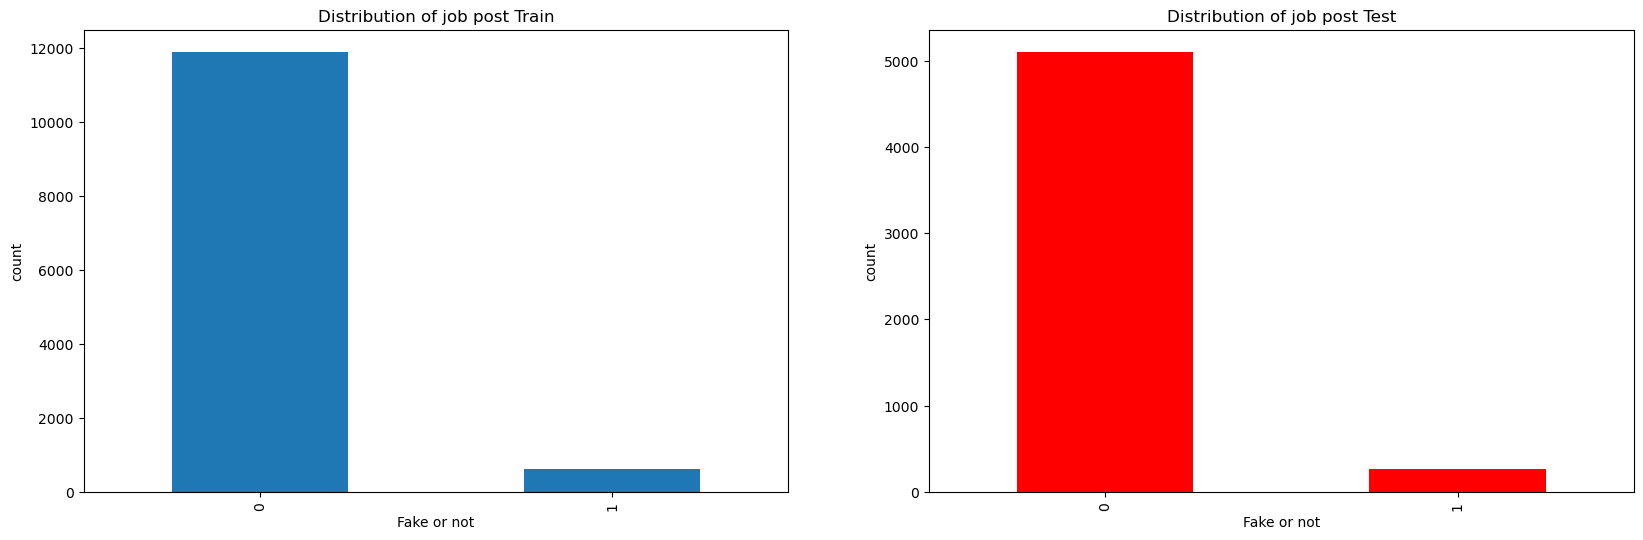

In [76]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
y_rem.value_counts().plot(kind='bar')
plt.title("Distribution of job post Train")
plt.xlabel("Fake or not")
plt.ylabel('count')

plt.subplot(1,2,2)
y_test.value_counts().plot(kind='bar',color='red')
plt.title("Distribution of job post Test")
plt.xlabel("Fake or not")
plt.ylabel('count')
plt.show()

- Data set is very embalanced, I need to balace the train set before modeling.
- I don't want to touch test set, as most of the process on the test set may cause data leaking, or introduce bias in the test set.

**Imbalanced data**

**Note** : I will only use SMOTE() on remder set.

In [276]:
smote = SMOTE(random_state=42)
X_rem_wv_smote, y_rem_smote = smote.fit_resample(X_rem_wv_df, y_rem)

In [277]:
X_rem_wv_smote.shape

(23818, 304)

In [278]:
y_rem_smote.value_counts()

0    11909
1    11909
Name: fraudulent, dtype: int64

In [456]:

# random seeds for reproducability

tf.random.set_seed(123)

# create a new sequential model
model = keras.Sequential()

model.add(layers.Dense(200, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(layers.Dense(1, activation="sigmoid")) # output

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(),tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
),tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)]
)


#model.add(Dense(units = 25 , activation = 'relu'))
#model.add(Dense(units = 10 , activation = 'relu'))

In [457]:
"""scale the data before any neural net"""
scl = preprocessing.StandardScaler()
wv_X_rem = scl.fit_transform(X_rem_wv_smote)
wv_X_test= scl.transform(X_test_wv_df)

In [458]:
history=model.fit(wv_X_rem.astype(np.float32), y=y_rem_smote, batch_size=32, 
          epochs=10, verbose=1, 
          validation_split=0.3)

Epoch 1/10
521/521 [==============================] - 4s 4ms/step - loss: 0.2763 - binary_accuracy: 0.8872 - recall_20: 0.8207 - precision_16: 0.7919 - val_loss: 0.1456 - val_binary_accuracy: 0.9468 - val_recall_20: 0.9468 - val_precision_16: 1.0000
Epoch 2/10
521/521 [==============================] - 2s 4ms/step - loss: 0.1263 - binary_accuracy: 0.9530 - recall_20: 0.9129 - precision_16: 0.9220 - val_loss: 0.0648 - val_binary_accuracy: 0.9769 - val_recall_20: 0.9769 - val_precision_16: 1.0000
Epoch 3/10
521/521 [==============================] - 2s 4ms/step - loss: 0.0969 - binary_accuracy: 0.9659 - recall_20: 0.9389 - precision_16: 0.9417 - val_loss: 0.0807 - val_binary_accuracy: 0.9731 - val_recall_20: 0.9731 - val_precision_16: 1.0000
Epoch 4/10
521/521 [==============================] - 2s 4ms/step - loss: 0.0742 - binary_accuracy: 0.9731 - recall_20: 0.9479 - precision_16: 0.9576 - val_loss: 0.0480 - val_binary_accuracy: 0.9831 - val_recall_20: 0.9831 - val_precision_16: 1.0000


In [461]:
# Evaluate the network
train_accuracy = history.history["binary_accuracy"][-1]
result = model.evaluate(wv_X_test,y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.9879
Test Accuracy: 0.9510


In [462]:
result1=model.predict(wv_X_test.astype(np.float32))

168/168 [==============================] - 0s 2ms/step


In [463]:
y_pred = np.where(result1>0.05,1,0)

In [464]:
result1[1]

array([7.824114e-06], dtype=float32)

In [465]:
y_pred.sum()

132

In [466]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5104
           1       0.39      0.20      0.26       260

    accuracy                           0.95      5364
   macro avg       0.67      0.59      0.62      5364
weighted avg       0.93      0.95      0.94      5364



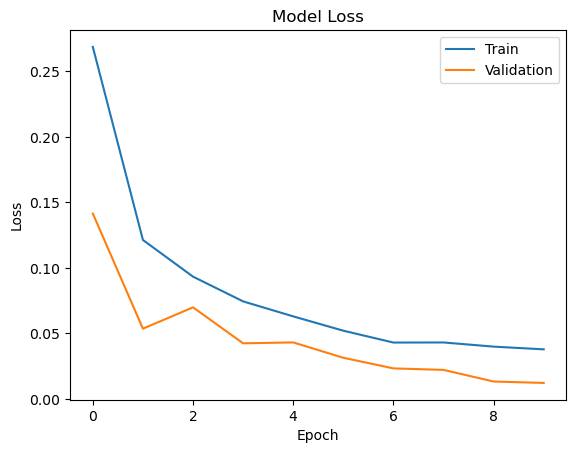

In [440]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#ax.set_xticks(list(range(1,21))
plt.legend(['Train', 'Validation'])
plt.show()

In [430]:
# Word2vec with logreg
pipe1 = imbPipeline([
    ('smote',SMOTE(random_state=42)),
    ('scaler',StandardScaler()),
    #('dim_reducer', PCA()),
    ('classifier',LogisticRegression())
])

# define C values
c_values=[0.001, 0.01, 0.1, 1, 10]


logistic_reg_grid=[
    # no pca
    {'classifier__C':c_values,
    'classifier': [LogisticRegression(penalty='l1', random_state=123, n_jobs=-1,max_iter=1000)],
    'classifier__solver':['saga']}  
]

In [337]:
# define GridSearch
halving_cv = HalvingGridSearchCV(pipe1, logistic_reg_grid, n_jobs=-1, min_resources="exhaust", factor=3,verbose=2)

In [338]:
# fit model
logreg_gs_count_fit=halving_cv.fit(X_rem_wv_smote,y_rem_smote)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 7939
max_resources_: 23818
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5
n_resources: 7939
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 1
n_candidates: 2
n_resources: 23817
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [340]:
logreg_gs_count_fit.predict(wv_X_test)

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [341]:
print(classification_report(y_test, logreg_gs_count_fit.predict(wv_X_test)))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5104
           1       0.22      0.30      0.26       260

    accuracy                           0.92      5364
   macro avg       0.59      0.63      0.61      5364
weighted avg       0.93      0.92      0.92      5364



In [105]:
array = np.array(y_test.values).astype('float32')

In [108]:
array

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [110]:
predictions.reshape(5364,)

array([3.5185349e-05, 3.0869009e-07, 1.0582235e-02, ..., 8.0792411e-08,
       2.8544750e-10, 5.0676288e-08], dtype=float32)

In [111]:
predictions.shape

(5364, 1)

In [104]:
log_reg=LogisticRegression()
log_reg.fit(X_rem_wv_smote,y_rem_smote)
log_reg.predict(X_test_wv_df)
coefficients=log_reg.coef_[0]

In [110]:
cof = pd.DataFrame(
    {"coefficients": coefficients},
    index=X_test_wv_df.columns
).sort_values("coefficients", ascending=False)
cof

,coefficients
252,8.791477
268,6.789299
146,6.701490
60,6.523205
295,6.349401
...,...
32,-5.963758
53,-5.973222
89,-6.259209
243,-6.579357
